# KNN, рак и спам
__Суммарное количество баллов: 12__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW01] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
from typing import NoReturn, Tuple, List

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [2]:
def read_cancer_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к cancer датасету.

    Returns
    -------
    X : np.array
        Матрица признаков опухолей.
    y : np.array
        Вектор бинарных меток, 1 соответствует злокачественной опухоли (M), 
        0 --- доброкачественной (B).

    
    """
    df = pd.read_csv(path_to_csv).sample(frac=1)
    return df.drop(['label'], axis=1).to_numpy(), \
            np.array([1 if x == 'M' else 0 for x in df['label'].to_numpy()])

def read_spam_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к spam датасету.

    Returns
    -------
    X : np.array
        Матрица признаков сообщений.
    y : np.array
        Вектор бинарных меток, 
        1 если сообщение содержит спам, 0 если не содержит.
    
    """
    df = pd.read_csv(path_to_csv).sample(frac=1)
    return df.drop(['label'], axis=1).to_numpy(), df['label'].to_numpy()

In [3]:
X, y = read_spam_dataset("spam.csv")

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [4]:
def train_test_split(X: np.array, y: np.array, ratio: float
                     ) -> Tuple[np.array, np.array, np.array, np.array]:
    """

    Parameters
    ----------
    X : np.array
        Матрица признаков.
    y : np.array
        Вектор меток.
    ratio : float
        Коэффициент разделения.

    Returns
    -------
    X_train : np.array
        Матрица признаков для train выборки.
    y_train : np.array
        Вектор меток для train выборки.
    X_test : np.array
        Матрица признаков для test выборки.
    y_test : np.array
        Вектор меток для test выборки.

    """
    num = round(X.shape[0] * ratio)
    return X[:num], y[:num], X[num:], y[num:]

In [5]:
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)

In [5]:
def normalise(X: np.array) -> np.array:
    """
    Parameters
    ----------
    X : np.array
        Данные, которые нужно нормализовать по формуле (x - min(x)) / (max(x) - min(x)).
    
    Returns
    -------
    X : np.array
        Нормализованные данные.
    """
    mins = np.amin(X, axis=0)
    maxs = np.amax(X, axis=0)
    for j in range(len(X[0])):
        for i in range(len(X)):
            X[i][j] = (X[i][j] - mins[j]) / (maxs[j] - mins[j])
    return X

### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [20]:
def get_precision_recall_accuracy(y_pred: np.array, y_true: np.array
                                  ) -> Tuple[np.array, np.array, float]:
    """

    Parameters
    ----------
    y_pred : np.array
        Вектор классов, предсказанных моделью.
    y_true : np.array
        Вектор истинных классов.

    Returns
    -------
    precision : np.array
        Вектор с precision для каждого класса.
    recall : np.array
        Вектор с recall для каждого класса.
    accuracy : float
        Значение метрики accuracy (одно для всех классов).

    """ 
    n = len(y_pred)
    classes = np.unique(list(y_pred) + list(y_true))
    precision, recall, accuracy = [], [], []
    for cl in classes:
        tp = sum(1 for i in range(n) if y_pred[i] == y_true[i] == cl)
        fp = sum(1 for i in range(n) if y_pred[i] == cl and y_true[i] != cl)
        tn = sum(1 for i in range(n) if y_pred[i] != cl and y_true[i] != cl)
        fn = sum(1 for i in range(n) if y_pred[i] != cl and y_true[i] == cl)
        
        # check for division by zero
        if not (tp + fp):
            precision.append(None)
        else: precision.append(tp / (tp + fp))
        
        if not (tp + fn):
            recall.append(None)
        else: recall.append(tp / (tp + fn))
        
        if not (tp + fp + tn + fn):
            accuracy.append(None)
        else:
            accuracy.append((tp + tn) / (tp + fp + tn + fn))
    
    
    return np.array(precision), np.array(recall), np.array(accuracy)

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [23]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [24]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь приступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачей во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [25]:
class Node:
    def __init__(self, feature, value, left, right):
        self.feature = feature
        self.value = value
        self.left = left
        self.right = right
        
    def __str__(self):
        return f"[left: {self.left}, right: {self.right}]"

class KDTree:
    def __init__(self, X: np.array, leaf_size: int = 40):
        """
        Parameters
        ----------
        X : np.array
            Набор точек, по которому строится дерево.
        leaf_size : int
            Минимальный размер листа
            (то есть, пока возможно, пространство разбивается на области,
            в которых не меньше leaf_size точек).

        Returns
        -------
        """
        self.X = X
        self.leaf_size = leaf_size
        self.tree = self.build_tree(0, X, leaf_size)

        
    def build_tree(self, feature: int, X: np.array, leaf_size: int):
        """
        Parameters
        ----------
        feature : int
            Колонка, по значению которой происходит переход по веткам.
        X : np.array
            Набор точек, по которому строится дерево.
        leaf_size : int
            Минимальный размер листа
            (то есть, пока возможно, пространство разбивается на области,
            в которых не меньше leaf_size точек).

        Returns
        -------
        Node
            Корень KD дерева.
        """

        if not len(X) or not leaf_size:
            return Node(feature=None, value=None, left=None, right=None)

        median = np.median(X, axis=0)[feature]
        left, right = [], []
        for item in X:
            if item[feature] <= median:
                left.append(item)
            else:
                right.append(item)
                
        if len(left) < leaf_size or len(right) < leaf_size:
            return X
        
        node = Node(feature=feature, value=median, left=left, right=right)

        # loop features
        feature += 1
        if feature == len(X[0]):
            feature = 0

        node.left = self.build_tree(feature, node.left, leaf_size)
        node.right = self.build_tree(feature, node.right, leaf_size)

        return node

    
    def query(self, X: np.array, k: int = 5) -> List[List]:
        """
        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно найти ближайших соседей.
        k : int
            Число ближайших соседей.

        Returns
        -------
        list[list]
            Список списков (длина каждого списка k):
            индексы k ближайших соседей для всех точек из X.

        """
        def get_bests(item, node, k):
            """
            Parameters
            ----------
            item : np.array
                Точка, для которой ищем ближайших.
            node : list[np.array]
                Список точек, среди которых ищем k ближайших.
            k : int
                Число соседей.
            
            Returns
            -------
            list[np.array]
                k ближайших среди заданного набора точек.
            """
            bests = list(sorted([(i, np.linalg.norm(x - item)) for i, x in enumerate(node)],
                                key=lambda x: x[1]))
            bests = [node[i] for i, d in bests]
            bests = bests[:min(k, len(bests))]
            return bests

        def search(node, item, k):
            """
            Parameters
            ----------
            node : Node or list
                Вершина KD дерева.
            item : np.array
                Заданная точка, для которой ищем соседей.
            k : int
                Число соседей.
            
            Returns
            list[np.array]
                k соседей для заданной точки.
            -------
            """
            if isinstance(node, list):
                return get_bests(item, node, k)

            if item[node.feature] <= node.value:
                bests = search(node.left, item, k)
                # if distance from the farthest is greater than distance to border
                distance = [0 for _ in range(len(item))]
                distance[node.feature] = item[node.feature] - node.value
                if np.linalg.norm(distance) < np.linalg.norm(item - bests[-1]):
                    bests += search(node.right, item, k)
                    bests = get_bests(item, bests, k)

            else:
                bests = search(node.right, item, k)
                distance = [0 for _ in range(len(item))]
                distance[node.feature] = item[node.feature] - node.value
                if np.linalg.norm(distance) < np.linalg.norm(item - bests[-1]):
                    bests += search(node.left, item, k)
                    bests = get_bests(item, bests, k)

            return bests
        
        output = [[] for _ in range(len(X))]
        for i in range(len(X)):
            output[i] = search(self.tree, X[i], k)

        # getting indices
        for i in range(len(output)):
            for j in range(len(output[i])):
                output[i][j] = np.where(np.all(self.X == output[i][j], axis=1))[0][0]

        return output

Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [26]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = np.random.randn(100, 3)
X_test = np.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
predicted = tree.query(X_test, k=4)
true = true_closest(X_train, X_test, k=4)

if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [27]:
class KNearest:
    def __init__(self, n_neighbors: int = 5, leaf_size: int = 30):
        """

        Parameters
        ----------
        n_neighbors : int
            Число соседей, по которым предсказывается класс.
        leaf_size : int
            Минимальный размер листа в KD-дереве.

        """        
        self.k = n_neighbors
        self.leaf_size = leaf_size
        self.KDTree = None
        self.y = None
        self.classes = None
    
    def fit(self, X: np.array, y: np.array) -> NoReturn:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которым строится классификатор.
        y : np.array
            Метки точек, по которым строится классификатор.

        """        
        self.KDTree = KDTree(X, self.leaf_size)
        self.y = y
        self.classes = len(np.unique(y))
        
    def predict_proba(self, X: np.array) -> List[np.array]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        list[np.array]
            Список np.array (длина каждого np.array равна числу классов):
            вероятности классов для каждой точки X.
            

        """
        neighbours = self.KDTree.query(X, self.k)
        output = [0] * len(X)
        for i in range(len(output)):
            point = neighbours[i]
            classes = [0] * self.classes
            for neighbour in point:
                class_ = self.y[neighbour]
                classes[class_] += 1
            output[i] = np.array([x / self.k for x in classes])
                
        return output
        
    def predict(self, X: np.array) -> np.array:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        np.array
            Вектор предсказанных классов.
            

        """
        return np.argmax(self.predict_proba(X), axis=1)


Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

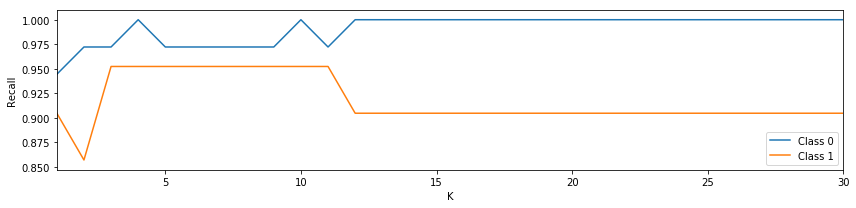

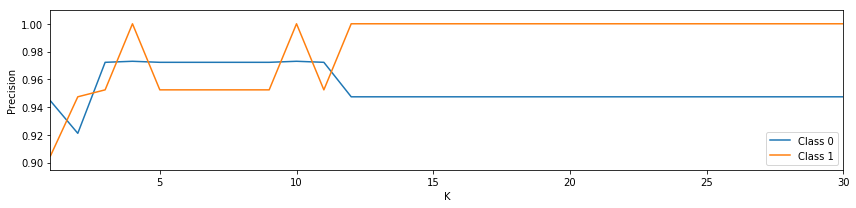

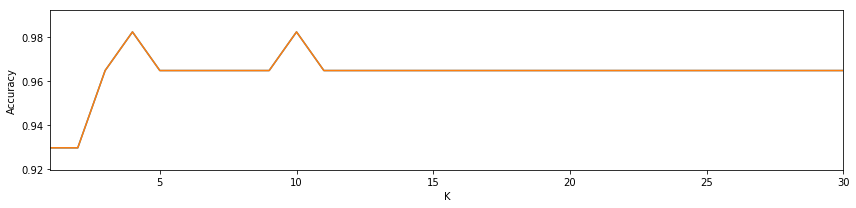

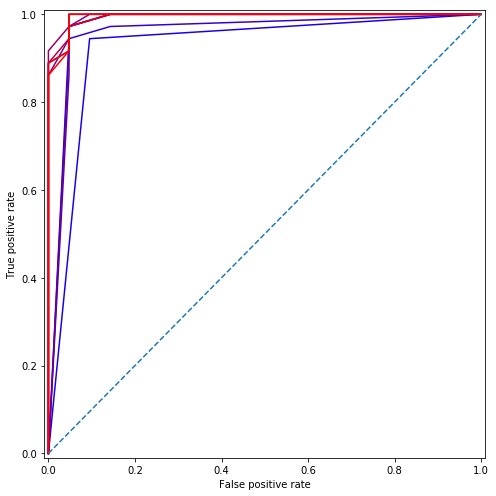

In [28]:
X, y = read_cancer_dataset("cancer.csv")
X = normalise(X)
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

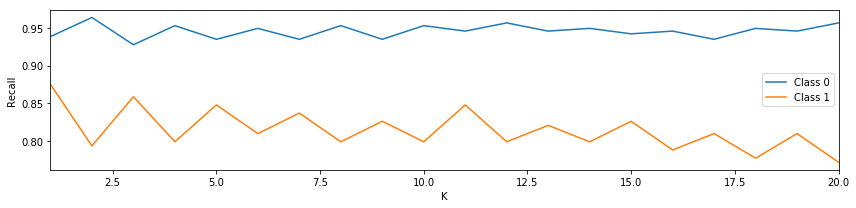

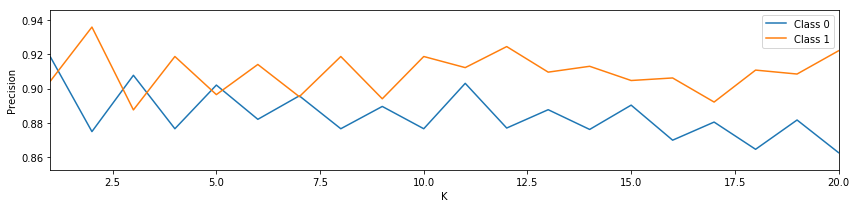

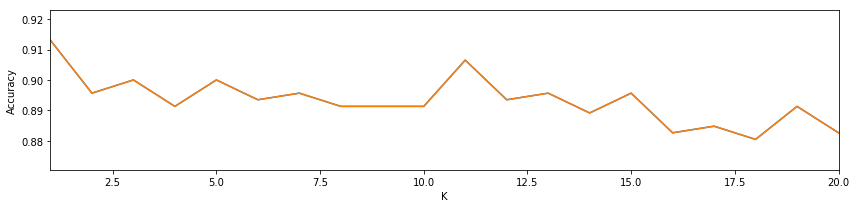

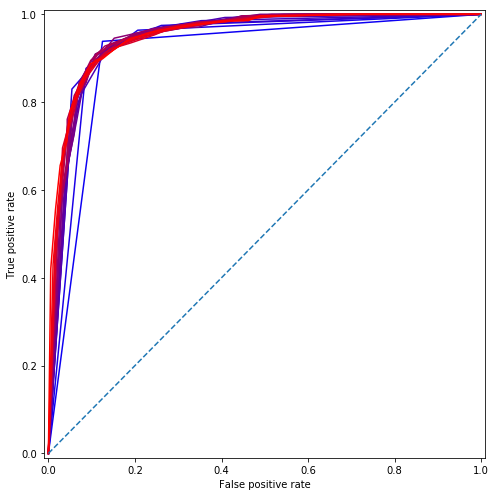

In [29]:
X, y = read_spam_dataset("spam.csv")
X = normalise(X)
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)